# Week 6 homeworks - God Spiked the Integers (chapter 11)

In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set(context="notebook", font_scale=1.2, rc={"figure.figsize": (12, 5)})
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

# Helper function
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()

1. *The data in NWOGrants.csv are outcomes for scientific funding applications for the Netherlands Organization for Scientic Research (NWO) from 2010–2012 (see [van der Lee and Ellemers](https://www.pnas.org/content/112/40/12349)). These data have a very similar structure to the UCBAdmit data discussed in Chapter 11.*

*I want you to consider a similar question: What are the total and indirect causal effects of gender on grant awards? Consider a mediation path (a pipe) through discipline. Draw the corresponding DAG and then use one or more binomial GLMs to answer the question.*

*What is your causal interpretation? If NWO’s goal is to equalize rates of funding between the genders, what type of intervention would be most effective?*

The implied DAG is:

![NWO DAG](img/nwo-dag.png)

where G is gender, D is discipline, and A is award. The direct causal effect of gender is the path G → A. The total effect includes that path and the indirect path G → D → A. We can estimate the total causal influence (assuming this DAG is correct) with a model that conditions only on gender. I’ll use a $Normal(-1, 1)$ prior for the intercepts, because we know from domain knowledge that less than half of applicants get awards.

Let's load the data and run first the total-effect model:

In [2]:
nwo = pd.read_csv("../Data/NWOGrants.csv", sep=";")
nwo["p_awards"] = nwo.awards / nwo.applications
discipline_id, disciplines = nwo.discipline.factorize()
gender_id, genders = nwo.gender.factorize()
nwo

,discipline,gender,applications,awards,p_awards
0,Chemical sciences,m,83,22,0.265060
1,Chemical sciences,f,39,10,0.256410
2,Physical sciences,m,135,26,0.192593
3,Physical sciences,f,39,9,0.230769
4,Physics,m,67,18,0.268657
5,Physics,f,9,2,0.222222
6,Humanities,m,230,33,0.143478
7,Humanities,f,166,32,0.192771
8,Technical sciences,m,189,30,0.158730
9,Technical sciences,f,62,13,0.209677


In [3]:
with pm.Model() as m_total:
    a = pm.Normal("a", -1.0, 1.0, shape=len(genders))

    p = pm.math.invlogit(a[gender_id])

    A = pm.Binomial("A", p=p, n=nwo.applications, observed=nwo.awards)

    trace_total = pm.sample(1000, tune=2000, cores=4, chains=2, random_seed=RANDOM_SEED)

post_total = pm.trace_to_dataframe(trace_total)
az.summary(trace_total, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:09<00:00, 624.50draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.53,0.06,-1.63,-1.43,0.0,0.0,2050.79,2045.88,2057.33,1472.56,1.0
a[1],-1.74,0.08,-1.86,-1.61,0.0,0.0,2105.18,2094.39,2113.60,1466.49,1.0


Gender 0 here is male and 1 is female. So males have higher rates of award, on average. How big is the difference? Let’s look at the contrast on absolute scale:

In [4]:
diff = logistic(post_total["a__0"]) - logistic(post_total["a__1"])
print(f"Mean diff: {diff.mean().round(2)}")
print(f"89% HPD: {az.hpd(diff, credible_interval=0.89).round(2)}")

Mean diff: 0.03
89% HPD: [0.01 0.05]


So a small 3% difference on average. Still, with such low funding rates (in some disciplines), 3% is a big advantage.

Now for the direct influence of gender, we condition on discipline as well:

In [5]:
with pm.Model() as m_direct:
    aG = pm.Normal("aG", -1.0, 1.0, shape=len(genders))
    aD = pm.Normal("aD", 0.0, 1.0, shape=len(disciplines))

    p = pm.Deterministic("p", pm.math.invlogit(aG[gender_id] + aD[discipline_id]))

    A = pm.Binomial("A", p=p, n=nwo.applications, observed=nwo.awards)

    trace_direct = pm.sample(
        1000,
        tune=2000,
        cores=4,
        chains=2,
        random_seed=RANDOM_SEED,
        nuts_kwargs={"target_accept": 0.9},
    )
    awards_ppc = pm.sample_posterior_predictive(trace_direct, var_names=["p", "A"])

post_direct = pm.trace_to_dataframe(trace_direct)
az.summary(trace_direct, var_names=["aG", "aD"], credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [aD, aG]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:29<00:00, 202.51draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 2000/2000 [00:04<00:00, 422.12it/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
aG[0],-1.35,0.29,-1.83,-0.89,0.01,0.01,408.65,395.56,413.03,485.91,1.0
aG[1],-1.49,0.30,-1.94,-1.00,0.01,0.01,422.23,409.09,423.84,560.51,1.0
aD[0],0.33,0.34,-0.21,0.87,0.01,0.01,567.03,551.82,569.27,731.04,1.0
aD[1],-0.01,0.34,-0.52,0.57,0.01,0.01,520.46,520.46,520.54,647.63,1.0
aD[2],0.30,0.38,-0.26,0.92,0.02,0.01,628.02,628.02,626.38,864.34,1.0
aD[3],-0.23,0.32,-0.77,0.24,0.01,0.01,457.68,457.68,461.52,547.66,1.0
aD[4],-0.20,0.32,-0.72,0.31,0.01,0.01,488.26,488.26,487.07,782.87,1.0
aD[5],-0.27,0.34,-0.81,0.27,0.02,0.01,515.42,515.42,517.58,688.62,1.0
aD[6],0.01,0.32,-0.50,0.55,0.02,0.01,454.72,454.72,455.49,638.40,1.0
aD[7],-0.45,0.30,-0.91,0.05,0.01,0.01,431.11,431.11,435.36,592.12,1.0


Those chains didn’t sample very efficiently. This is likely because the model is over-parameterized -- it has more parameters than absolutely necessary. This doesn’t break it. It just makes the sampling less efficient. Anyway, now we can compute the gender difference again:

In [6]:
diff = logistic(post_direct["aG__0"]) - logistic(post_direct["aG__1"])
print(f"Mean diff: {diff.mean().round(2)}")
print(f"89% HPD: {az.hpd(diff, credible_interval=0.89).round(3)}")

Mean diff: 0.02
89% HPD: [-0.004  0.052]


Still an advantage for the males, but reduced and overlapping zero a bit. To really see this difference though, we need to account for the base rates in each discipline as well. Let's check this with some posterior predictions:

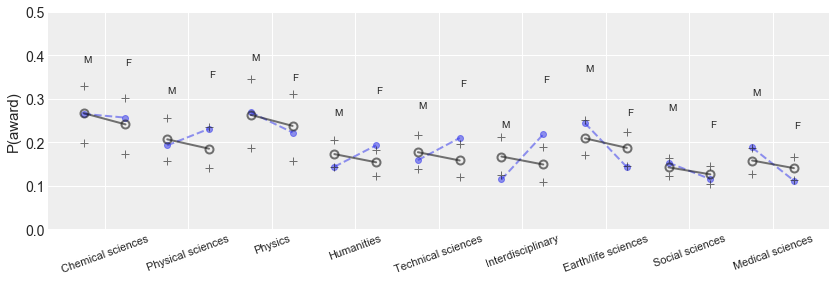

In [7]:
obs_props = nwo.p_awards
pred_props = awards_ppc["p"].mean(0)
pred_hpds = az.hpd(awards_ppc["p"], credible_interval=0.89)
tick_locs = []

plt.figure(figsize=(14, 4))
for i in range(len(nwo) // 2):
    x = 2 * i  # keep i even
    plt.plot([x, x + 1], [obs_props[x], obs_props[x + 1]], "--C0o", lw=2, alpha=0.5)
    plt.plot(
        [x, x + 1],
        [pred_props[x], pred_props[x + 1]],
        "-ko",
        fillstyle="none",
        ms=8,
        markeredgewidth=2,
        lw=2,
        alpha=0.6,
    )
    plt.plot([x, x], [pred_hpds[x][0], pred_hpds[x][1]], "k+", ms=8, alpha=0.6)
    plt.plot(
        [x + 1, x + 1],
        [pred_hpds[x + 1][0], pred_hpds[x + 1][1]],
        "k+",
        ms=8,
        alpha=0.6,
    )
    plt.text(x, obs_props[x] + 0.12, nwo.gender[x].upper(), fontsize=10)
    plt.text(x + 1, obs_props[x + 1] + 0.12, nwo.gender[x + 1].upper(), fontsize=10)
    tick_locs.append(x + 0.5)
plt.xticks(tick_locs, disciplines.values, rotation=20, fontsize=11)
plt.ylabel("P(award)")
plt.ylim(0, 0.5);

This graph is a little complicated, but conveys a lot of information. Blue points are observed proportions of grants awarded for each discipline and each gender -- points from the same discipline are connected by a blue line. Open gray points and crosses are the expected proportions and 89% intervals of simulated samples respectively, according to the model.

We can see that the predictive differences -- the gray lines -- are very small. There are also several disciplines that reverse the advantage. -- the model doesn't seem very good at handling them by the way. So, if there is a direct influence of gender here, it is small, much smaller than before we accounted for discipline. 

Why? Because, like in the chapter, the disciplines have different funding rates and women apply more to the disciplines with lower funding rates: if you go back to the parameter summary of the model, you'll see that disciplines 0 and 2 (chemical sciences and physics) have the highest funding rates, while 7 and 8 (social and medical sciences) have the lowest. Let's look now at the proportions of male and female applications in each discipline:

In [8]:
p_g = pd.DataFrame(index=["m", "f"], columns=disciplines)
for d in disciplines:
    p_g[d] = (
        nwo.loc[nwo.discipline == d, "applications"]
        / nwo.loc[nwo.discipline == d, "applications"].sum()
    ).values
p_g.round(2)

,Chemical sciences,Physical sciences,Physics,Humanities,Technical sciences,Interdisciplinary,Earth/life sciences,Social sciences,Medical sciences
m,0.68,0.78,0.88,0.58,0.75,0.57,0.55,0.51,0.49
f,0.32,0.22,0.12,0.42,0.25,0.43,0.45,0.49,0.51


And indeed, women applied more to grants in social and medical sciences than in physics or the chemical sciences. But it would be hasty, I think, to conclude there are no other influences. There are after all lots of unmeasured confounds...

2. *Suppose that the NWO Grants sample has an unobserved confound that influences both choice of discipline and the probability of an award. One example of such a confound could be the career stage of each applicant. Suppose that in some disciplines, junior scholars apply for most of the grants. In other disciplines, scholars from all career stages compete. As a result, career stage influences discipline as well as the probability of being awarded a grant.*

*Add these influences to your DAG from Problem 1. What happens now when you condition on discipline? Does it provide an un-confounded estimate of the direct path from gender to an award? Why or why not? Justify your answer with the back-door criterion. Hint: this is structurally a lot like the grandparents-parents-children-neighborhoods example from the chapter.*

*If you have trouble thinking this through, try simulating fake data, assuming your DAG is true. Then analyze it using the model from Problem 1. What do you conclude? Is it possible for gender to have a real direct causal influence but for a regression conditioning on both gender and discipline to suggest zero influence?*

The implied DAG is:

![COLLIDER DAG](img/collider-dag.png)

where S is stage of career (unobserved). This DAG has the same structure as the grandparents-parents-children-neighborhoods example from the chapter. Now, D is a collider. So, when we condition on discipline it opens a backdoor path through S to A. It is not possible here to get an unconfounded estimate of gender on awards (i.e a direct path). Not convinced? Fair enough! Here’s a simulation to demonstrate the potential issue:

In [9]:
N = 1000
G = np.random.binomial(n=1, p=0.5, size=N)
S = np.random.binomial(n=1, p=0.5, size=N)
D = np.random.binomial(n=1, p=logistic(G + S), size=N)
A = np.random.binomial(n=1, p=logistic(-2 + 0.25 * G + D + 2 * S), size=N)

This code simulates 1000 applicants. There are 2 genders (G 0/1), 2 stages of career (S 0/1), and 2 disciplines (D 0/1). Discipline 1 is chosen more by gender 1 and career stage 1 -- so that could mean more by males and later stage of career. Then awards A have a consistent bias towards gender 1, and discipline 1 has a higher award rate, and stage 1 also a higher award rate. If we analyze these data with the second model from Problem 1:

In [10]:
with pm.Model() as m_sim:
    a = pm.Normal("a", 0.0, 1.0)
    g = pm.Normal("g", 0.0, 1.0)
    d = pm.Normal("d", 0.0, 1.0)

    D_ = pm.Data("D", D)
    A_ = pm.Data("A", A)
    p = pm.math.invlogit(a + g * G + d * D_)

    awards = pm.Bernoulli("awards", p=p, observed=A_)
    trace_sim = pm.sample(1000, tune=2000, cores=4, chains=2, random_seed=RANDOM_SEED)

az.summary(trace_sim, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [d, g, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:48<00:00, 124.67draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.83,0.13,-1.04,-0.62,0.0,0.0,1163.62,1163.62,1159.72,1058.69,1.0
g,0.19,0.13,0.00,0.41,0.0,0.0,1456.63,1401.87,1460.26,1278.60,1.0
d,0.86,0.15,0.62,1.10,0.0,0.0,1219.67,1216.83,1215.18,1171.69,1.0


The parameter `g` is the advantage of gender 1. It is smaller than the true advantage and the posterior distribution straddles zero, even with 1000 applicants. Maybe with another random seed the `g` estimate would be even smaller than the true value, but we can already see the potential issue here: because of the collider bias, it is possible for gender to have a real direct causal influence but for a regression conditioning on both gender and discipline to suggest zero influence.

Note however that it can also be the other way around: there can be no real gender influence, but we infer there is one by accident. Try these settings:

In [11]:
with m_sim:
    pm.set_data(
        {
            "D": np.random.binomial(n=1, p=logistic(2 * G - S), size=N),
            "A": np.random.binomial(n=1, p=logistic(-2 + 0 * G + D + S), size=N),
        }
    )
    trace_sim2 = pm.sample(1000, tune=2000, cores=4, chains=2, random_seed=RANDOM_SEED)

az.summary(trace_sim2, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [d, g, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:35<00:00, 170.83draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.68,0.11,-0.84,-0.51,0.0,0.0,1235.97,1235.97,1240.79,1133.54,1.0
g,0.39,0.15,0.15,0.63,0.0,0.0,1254.23,1239.08,1254.23,1095.99,1.0
d,-0.18,0.15,-0.43,0.05,0.0,0.0,980.25,876.50,971.25,877.70,1.0


Now it looks like gender 1 has a consistent advantage, but in fact there is no advantage in the simulation -- the posterior for `g` doesn't even contains the true value of the parameter, as it is reliably above 0.

3. *The data in primates301.csv were first introduced at the end of chapter 7. In this problem, you will consider how brain size is associated with social learning. There are three parts.*

*First, model the number of observations of `social_learning` for each species as a function of the log `brain_size`. Use a Poisson distribution for the `social_learning` outcome variable. Interpret the resulting posterior.*

*Second, some species are studied much more than others. So the number of reported instances of `social_learning` could be a product of research effort. Use the `research_effort` variable, specifically its logarithm, as an additional predictor variable. Interpret the coefficient for log `research_effort`. Does this model disagree with the previous one?*

*Third, draw a DAG to represent how you think the variables `social_learning`, `brain`, and `research_effort` interact. Justify the DAG with the measured associations in the two models above (and any other models you used).*

First let’s load the data and set it up for use:

In [12]:
d = (
    pd.read_csv("../Data/primates301.csv", sep=";")[
        ["social_learning", "brain", "research_effort", "genus"]
    ]
    .dropna()
    .reset_index(drop=True)
)

soc_learn = d.social_learning.astype(int).values
log_brain = stdz(np.log(d.brain)).values
log_effort = np.log(d.research_effort).values

Now we first want a model with social learning as the outcome and log brain size as a predictor. For this Poisson GLM, we're going to use a *Normal(0,1)* prior on the intercept, since we know the counts should be small. Let's do prior predictive checks to figure out a reasonable prior for the slope:

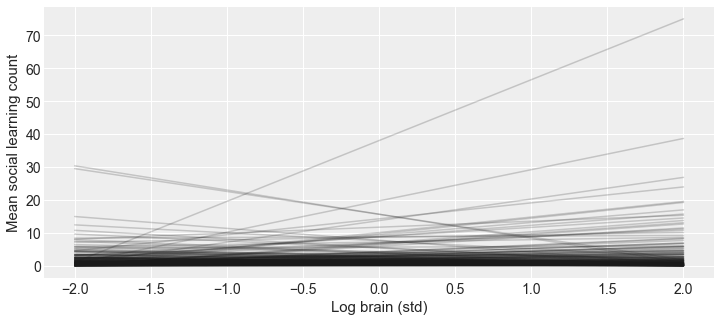

In [13]:
a_s = pm.Normal.dist(mu=0.0, sd=1.0).random(size=200)
bB_s = pm.Normal.dist(mu=0.0, sd=0.5).random(size=200)

plt.figure(figsize=(12, 5))
for y_s in zip(np.exp(a_s - 2 * bB_s), np.exp(a_s + 2 * bB_s)):
    plt.plot([-2, 2], y_s, color="k", alpha=0.2)
plt.xlabel("Log brain (std)")
plt.ylabel("Mean social learning count");

In [14]:
with pm.Model() as m3_1:
    a = pm.Normal("a", 0.0, 1.0)
    bB = pm.Normal("bB", 0.0, 0.5)
    lam = pm.math.exp(a + bB * log_brain)

    S = pm.Poisson("S", mu=lam, observed=soc_learn)

    trace_m3_1 = pm.sample(1000, tune=2000, cores=4, chains=2, random_seed=RANDOM_SEED)
    post_checks3_1 = pm.sample_posterior_predictive(trace_m3_1, random_seed=RANDOM_SEED)

idata1 = az.from_pymc3(trace=trace_m3_1, posterior_predictive=post_checks3_1)
az.summary(idata1, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [bB, a]
100%|██████████| 2000/2000 [00:04<00:00, 419.15it/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-1.17,0.12,-1.34,-0.97,0.0,0.0,702.15,697.27,699.00,814.85,1.0
bB,2.76,0.07,2.65,2.87,0.0,0.0,664.65,664.35,664.95,732.71,1.0


Brain size seems to be strongly associated with social learning observations. Let’s look at the posterior predictions:

/anaconda/envs/fund/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/anaconda/envs/fund/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


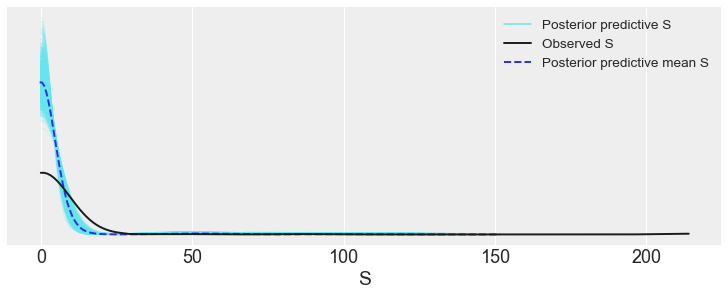

In [15]:
az.plot_ppc(idata1, random_seed=RANDOM_SEED, figsize=(10, 4));

These are not great posterior predictions. Clearly other factors are in play. Let’s try the research effort variable now:

In [16]:
with pm.Model() as m3_2:
    a = pm.Normal("a", 0.0, 1.0)
    bB = pm.Normal("bB", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)
    lam = pm.math.exp(a + bB * log_brain + bE * log_effort)

    S = pm.Poisson("S", mu=lam, observed=soc_learn)

    trace_m3_2 = pm.sample(1000, tune=2000, cores=4, chains=2, random_seed=RANDOM_SEED)
    post_checks3_2 = pm.sample_posterior_predictive(trace_m3_2, random_seed=RANDOM_SEED)

idata2 = az.from_pymc3(trace=trace_m3_2, posterior_predictive=post_checks3_2)
az.summary(idata2, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [bE, bB, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:44<00:00, 134.01draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 2000/2000 [00:06<00:00, 332.70it/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-5.95,0.32,-6.47,-5.45,0.02,0.01,455.29,455.29,455.59,456.68,1.0
bB,0.46,0.09,0.32,0.60,0.00,0.00,554.15,546.91,559.13,744.56,1.0
bE,1.53,0.07,1.41,1.63,0.00,0.00,417.39,417.39,416.01,617.79,1.0


Brain size `bB` is still positively associated, but much less. Research effort, `bE`, is strongly associated. To see how these models disagree, let’s use pointwise WAIC to see which cases each predicts well:

In [17]:
waic1 = az.waic(idata1, pointwise=True)["waic_i"].data
waic2 = az.waic(idata2, pointwise=True)["waic_i"].data
d_waic = waic1 - waic2

thresh = 25
big_waic_idx = np.where((d_waic < -thresh) | (d_waic > thresh))[0]

/anaconda/envs/fund/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Text(0, 0.5, 'log effort')

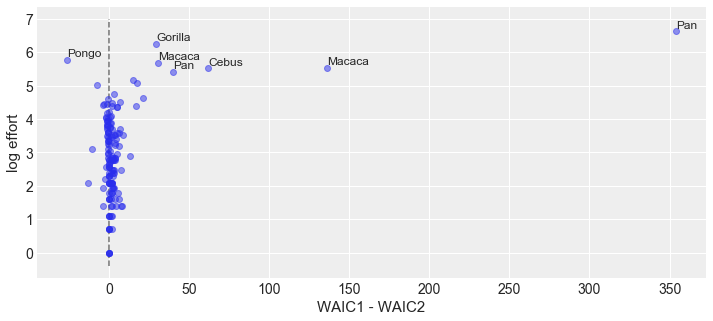

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(d_waic, log_effort, "o", alpha=0.5)
plt.vlines(0, -0.4, 7, linestyles="dashed", alpha=0.6)
for idx in big_waic_idx:
    plt.text(d_waic[idx], log_effort[idx] + 0.1, d.genus[idx], fontsize=12)
plt.xlabel("WAIC1 - WAIC2")
plt.ylabel("log effort");

Species on the right of the vertical line fit better with model m3_2, the model with research effort. These are mostly species that are studied a lot, like chimpanzees (Pan) and macaques (Macaca). The genus Pan especially has been a focus of social learning research, and its counts are inflated by this.

This is a good example of how the nature of measurement influences inference. There are likely a lot of false zeros in these data -- species that are not studied often enough to get a good idea of their learning tendencies. Meanwhile every time a chimpanzee sneezes, someone writes a social learning paper.

Okay, finally, I asked for a DAG. This is my guess:

![EFFORTS DAG](img/efforts-dag.png)

B is brain size, E is research effort, and S is social learning. Research effort doesn’t actually influence social learning, but it does influence the value of the variable. The model results above are consistent with this DAG in the sense that including E reduced the association with B, which we would expect when we close the indirect path through E. If researchers choose to look for social learning in species with large brains, this leads to an exaggerated estimate of the association between brains and social learning.

In [19]:
%watermark -a AlexAndorra -n -u -v -m -iv

seaborn    0.9.0
pandas     0.25.1
pymc3      3.7
numpy      1.16.5
theano     1.0.4
scipy      1.3.1
arviz      0.5.1
matplotlib 3.1.1
AlexAndorra 
last updated: Wed Oct 30 2019 

CPython 3.7.4
IPython 7.8.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit
